# A Tutorial for using Bandits for Travel Page Layout Optimization

Based on [An Efficient Bandit Algorithm for Realtime Multivariate Optimization](https://arxiv.org/pdf/1810.09558.pdf), Daniel Hill et. al. (Amazon.com) KDD'17

In [4]:
import pandas as pd
import random
import numpy as np
from scipy.stats import norm, bernoulli, beta
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import itertools

%matplotlib inline
 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

np.random.seed(42)

## Prologue: Multi-armed bandits

Suppose you enter a casino with multiple slot machines. You are told that there are some slot machines that have a higher probability of payout (or reward) than others. However, which machine that is more likely to reward you is unbenownst to you. 

**Your goal is to play the machines and try to get the highest reward possible.**

While you do this, you perhaps want to try testing the machines to try use the history to update a model for inferring each machine's probability of reward- or the model parameter. You do not have the model parameter $p$ for each machine, yet you can try to infer the value of $p$ given the number of successes or failures. For example, if you have 3 machines, you could model the probabilities for each with a vector $p = [0.2, 0.7, 0.4]$.

![bandits](diagrams/bandits.png)

You can track the behavior history for each machine as a vector. $S$ for number of successes, $F$ for failures:

\begin{equation*}
\mathbb{E}[R|S,F] = \frac{S}{S + F}
\end{equation*}

\begin{equation*}
\arg \max_i \mathbb{E}[R_i|S_i,F_i] = \frac{S_i}{S_i + F_i}
\end{equation*}

Fortunately, since this is a simple Bernoulli experiment, it is easy to model the behavior. The number of successes or failures are determined by the [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) (which is just a special case of the binomial distribution with just 1 trial) resulting in a binary value- reward or no reward. Each iteration, you could use the expectation using history to choose the machine you believe is the best. There are multiple strategies one can take:










### Greedy algorithm

Let's just select the machine with the highest expectation each iteration.

Problems:

- You get really unlucky and bit a machine with a low $p$ but it pays out
- No chance to explore better options if you found a machine that works for you


In [11]:
def greedy(S, F):

    probs = (S + 1)/(S + F + 1)
    
    return np.argmax(probs)

### E-Greedy algorithm

Select the machine with the highest expectation each iteration, but a certain fraction of time ($\epsilon$) explore other random options.

Good for mixing _exploration vs. exploitation_. 

Problems:

- Does not factor in the successes or failures for other candidates accordingly

In [20]:
def egreedy(S, F, epsilon=0.1):

    explore = np.random.random()
    
    if explore < epsilon:
        N = len(S)
        return np.random.randint(N)
    
    return greedy(S, F)

### Bernoulli Thompson sampling

Select the machine with the highest probability sampled from the posterior distribution.

Consider that the probability of a known p resulting in a reward is defined by the Bernoulli probability mass function:

\begin{equation*}
f(k; p) = p^k(1-p)^{1-p} k \in 0, 1
\end{equation*}

There is a conjugate prior that allows us to estimate the probability given the number of successes or failures you have observed. The [beta function](https://en.wikipedia.org/wiki/Beta_function). If we have observed data each machine, we can form a distribution of belief that the probability will be some value. 

Note, we used the Beta priors of 1, 1 initially.

In [18]:
def thompson(S, F):
    probs = np.random.beta(S + 1, F + 1)
    return np.argmax(probs)

Let's run an experiment with with 30 trials. The unknown model parameters, $p=[0.2, 0.7, 0.5]$.

In [9]:
def plot_beliefs(t, S, F):
    x = np.linspace(0, 1, 100)
    N = len(S)
    
    plt.figure(t)
    
    for i in range(N): 
        y = beta.pdf(x, S[i] + 1, F[i] + 1)
        plt.plot(x, y, label="Machine {}".format(i))
        plt.fill_between(x, 0, y, alpha=0.4)
        
    plt.title('trial {}'.format(t))
    plt.legend()


Chose machine 0
Won!
Successes:	[1 0 0]
Failures:	[0 0 0]
Chose machine 2
Won!
Successes:	[1 0 1]
Failures:	[0 0 0]
Chose machine 0
Lost...
Successes:	[1 0 1]
Failures:	[1 0 0]
Chose machine 1
Won!
Successes:	[1 1 1]
Failures:	[1 0 0]
Chose machine 1
Won!
Successes:	[1 2 1]
Failures:	[1 0 0]
Chose machine 1
Won!
Successes:	[1 3 1]
Failures:	[1 0 0]
Chose machine 1
Won!
Successes:	[1 4 1]
Failures:	[1 0 0]
Chose machine 2
Lost...
Successes:	[1 4 1]
Failures:	[1 0 1]
Chose machine 1
Won!
Successes:	[1 5 1]
Failures:	[1 0 1]
Chose machine 1
Won!
Successes:	[1 6 1]
Failures:	[1 0 1]
Chose machine 1
Won!
Successes:	[1 7 1]
Failures:	[1 0 1]
Chose machine 1
Won!
Successes:	[1 8 1]
Failures:	[1 0 1]
Chose machine 1
Won!
Successes:	[1 9 1]
Failures:	[1 0 1]
Chose machine 1
Lost...
Successes:	[1 9 1]
Failures:	[1 1 1]
Chose machine 1
Lost...
Successes:	[1 9 1]
Failures:	[1 2 1]
Chose machine 1
Won!
Successes:	[ 1 10  1]
Failures:	[1 2 1]
Chose machine 1
Won!
Successes:	[ 1 11  1]
Failures:	[1 2

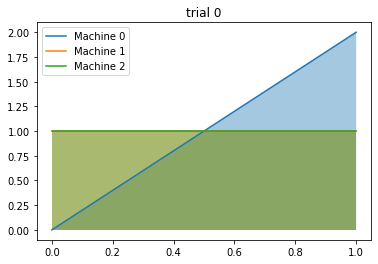

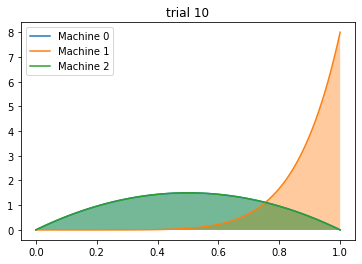

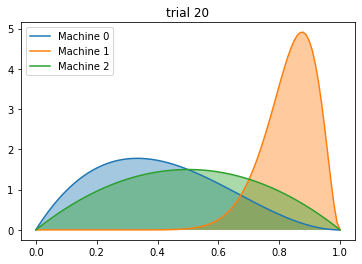

In [19]:
n_trials = 30
p = [0.2, 0.7, 0.5]
N = len(p)

S = np.zeros(N, dtype=np.uint8)
F = np.zeros(N, dtype=np.uint8)

for t in range(n_trials):
    machine = thompson(S, F)
    
    print("Chose machine {}".format(machine))
    
    r = np.random.random()
    
    if r < p[machine]:
        print("Won!")
        S[machine] += 1
    
    else:
        print("Lost...")
        F[machine] += 1
        
    print("Successes:\t{}".format(S))
    print("Failures:\t{}".format(F))
        
    if t % 10 == 0:
        plot_beliefs(t, S, F)
        
print("Experiment Results")
print("Total wins:\t{}".format(np.sum(S)))
print("Total losses:\t{}".format(np.sum(F)))


## The Page Layout Problem

Suppose you are responsible for choosing which content goes on a web page. The page has a static layout containing multiple slots to put content. Each slot can only contain one type of content. For example, this is what appears when a user [searches for Barcelona].(https://www.vrbo.com/vacation-rentals/europe/spain/catalunya/barcelona-province/barcelona)

It contains several widgets:

![widgets](pictures/vrbo-widgets.png)

Maybe there are some (pair-wise) interactions where placing the weather widget and the year pricing widget on the page at the same time boosts the chance of a reward more than the sum of its parts.

In this case, the number of potential layouts, $A$, are $3 \times 3 \times 2 = 18$

If we assume each slot can contain $N$ types of content, and there are $D$ slots then there are $N^D$ potential layouts. Quickly becomes a **combinatorial explosion!**

We can add context, $X$, such as time of year or user history so that perhaps certain widgets should be presented more often based on a user's viewing habit.

A feature vector can be formed $B_{A, X}$ combining layout and context.

Let's assume that a reward, $R$, could be that a booking was eventually made. $R \in \{-1, 1\}$

We can store the history $H_t$ of all the layouts users have seen as a tuple, $(A_t, X_t, R_t)$. 

For example, let's use this as the layouts:

- Slot 1: 
    1. "suit your style"
    2. map
    3. top rated
- Slot 2: 
    1. city info
    2. weather
    3. pricing
- Slot 3:
    1. reviews
    2. destination guide
    
There are therefore 18 potential layouts.

## Generate random simulated data

Let's generate artificially some random combinations of content and assign the value for reward:

- If reviews is in slot 3 then a booking is $p=0.4$ likely.
- But if reviews is in slot 3 and top rated rentals are shown in slot 1 then a booking is $p=0.7$ likely.
- In all other cases, bookings are $p=0.2$ likely

This is highly simplistic example, but it does allow us to represent randomness with a Bernoulli trial. Every time we expose a user to a page layout we draw a random sample that is binary- a reward was received or not. This example demonstrates interaction effects as well since if top rated and reviews are selected, the probability of getting a reward is higher.

Note that the parameters of the model cannot be directly known. It can only be estimated given the observed behavior.


In [22]:
def simulate_behavior(s1, s2, s3):
    """return whether a reward happened or not"""
    
    # draw a uniform random sample
    r = np.random.random()
    
    if s1 == 'top_rated' and s3 =='reviews':
        p = 0.7

    elif s3 == 'reviews':
        p = 0.4
        
    else: 
        p = 0.2
    
    # return 1 or -1 for reward/no reward
    return 1 if r > p else -1


In [23]:
choices_slot_1 = ["suit_style", "map", "top_rated"]
choices_slot_2 = ["city_info", "weather", "pricing"]
choices_slot_3 = ["reviews", "destination_guide"]
device_choices = ["web", "mobile"]

# number of random layouts to generate
N = 5

# generate random layouts
s1 = random.choices(choices_slot_1, k=N)
s2 = random.choices(choices_slot_2, k=N)
s3 = random.choices(choices_slot_3, k=N)

data = {'slot1': s1, 'slot2': s2, 'slot3': s3, 'reward': np.NaN}
H = pd.DataFrame(data=data, dtype='category')
H["slot1"] = H["slot1"].cat.set_categories(choices_slot_1)
H["slot2"] = H["slot2"].cat.set_categories(choices_slot_2)
H["slot3"] = H["slot3"].cat.set_categories(choices_slot_3)

    
def to_features(df):
    """convert the slots to a feature vector"""
    
    df1 = df.copy()
    
    if 'reward' in df1.columns:
        df1 = df1.drop(columns=["reward"])

    df1["bias"] = 1
        
    # convert the slots to indicator variables
    df1 = pd.get_dummies(df1, columns=["slot1", "slot2", "slot3"])
        
    # add the pairwise slot interactions
    
    # add the context
    
    # add the pairwise context-slot interactions
    return df1

def to_categories(df, columns):
    """converts a feature vector to slots"""
    cat_df = pd.DataFrame()
    
    for col in columns:
        c = df.loc[:, df.columns.str.startswith(col)].idxmax(axis=1).str[len(col + '_'):]
        cat_df[col] = c
    return cat_df
    
def simulate(df):
    """Adds a reward columns"""
    df['reward'] = df.apply(lambda x: simulate_behavior(x['slot1'], x['slot2'], x['slot3']), axis=1)
    return df
    
H_features = to_features(H)
H_slots = to_categories(H_features, ["slot1", "slot2", "slot3"])

display("History", H)
display("Features", H_features)
display(H_slots)
H = simulate(H)
display("History after simulating", H)



'History'

,slot1,slot2,slot3,reward
0,top_rated,city_info,destination_guide,NaN
1,map,city_info,reviews,NaN
2,top_rated,pricing,destination_guide,NaN
3,top_rated,weather,destination_guide,NaN
4,suit_style,pricing,destination_guide,NaN


'Features'

,bias,slot1_suit_style,slot1_map,slot1_top_rated,slot2_city_info,slot2_weather,slot2_pricing,slot3_reviews,slot3_destination_guide
0,1,0,0,1,1,0,0,0,1
1,1,0,1,0,1,0,0,1,0
2,1,0,0,1,0,0,1,0,1
3,1,0,0,1,0,1,0,0,1
4,1,1,0,0,0,0,1,0,1


,slot1,slot2,slot3
0,top_rated,city_info,destination_guide
1,map,city_info,reviews
2,top_rated,pricing,destination_guide
3,top_rated,weather,destination_guide
4,suit_style,pricing,destination_guide


'History after simulating'

,slot1,slot2,slot3,reward
0,top_rated,city_info,destination_guide,1
1,map,city_info,reviews,1
2,top_rated,pricing,destination_guide,-1
3,top_rated,weather,destination_guide,1
4,suit_style,pricing,destination_guide,1


## Online Learning

![feedback loop](diagrams/feedback.png)

Let's model the reward as a [probit model](https://en.wikipedia.org/wiki/Probit_model) and the argument as a sum of weighted Gaussians modelled as a vector of regressors $W$. $\Phi$ is the cumulative distribution function (CDF) of the standard normal distribution.

\begin{equation*}
p(R | A, X) = \Phi(R * B^TW)
\end{equation*}

Just slots and slot interactions:

\begin{equation*}
B^TW = W_0 + \sum_{i=0}{W_i}(A) + \sum_{j=1}\sum_{k=j+1}{W_{i, j}}(A)
\end{equation*}

Adding context:

\begin{equation*}
B^TW = W_0 + \sum_{i=1}{W_i}(A) + \sum_{j=1}\sum_{k=j+1}{W_{j, k}}(A) + \sum_{l=1}{W_l}(X) + \sum_{j=1}\sum_{k=j+1}{W_{j, k}}(X)
\end{equation*}

Using scaling factors:

\begin{equation*}
B^TW = \frac{1}{\beta}[W_0 + \alpha_1\sum_{i=1}{W_i}(A) + \alpha_2\sum_{j=1}\sum_{k=j+1}{W_{j, k}}(A) + \alpha_c\sum_{l=1}{W_l}(X) + \alpha_c\sum_{j=1}\sum_{k=j+1}{W_{j, k}}(X)]
\end{equation*}

Refer to [Web-scale Bayesian Click-Through Rate Prediction for Sponsored Search Advertising in Microsoft's Bing Search Engine]() Thore Graepel, et. al. (Microsoft.com), ICML 2010

\begin{align}
p(y | x, W) = \Phi(\frac{y \cdot w^T x}{\beta})
\end{align}


total variance:

\begin{align}
\Sigma^2 = \beta^2 + x^T*\sigma^2
\end{align}

Update the posterior values:
\begin{align}
\mu & := \mu + y x * \frac{\sigma^2}{\Sigma} \cdot v(\frac{y \cdot x^T\mu}{\Sigma}) \\
\sigma^2 & := \sigma^2 \cdot [1 - x \cdot \frac{\sigma^2}{\Sigma^2} \cdot w(\frac{y \cdot x^T\mu}{\Sigma}] \\
v(t) & = \frac{\mathcal{N}(t; 0, 1)}{\Phi(t; 0, 1)} \\
w(t) & = v(t) \cdot [v(t) + t]
\end{align}


In [224]:
def v(t):
    return norm.pdf(t)/norm.cdf(t)

def w(t):
    return v(t) * (v(t) + t)

def update(mu, sigma, feature, reward, beta=1):
    """update the means and variance based on the feature and reward"""
    variance = beta**2 + feature*sigma**2
    Sigma = np.sqrt(variance)
        
    mu = mu + reward * feature * sigma**2/Sigma * v(reward*feature*np.mean(mu)/Sigma)
    sigma = sigma * (1 - feature * sigma**2/Sigma * w(reward * feature * np.mean(mu)/Sigma))
    return mu, sigma

In [225]:
def plot_weights(mu, sigma, t):
    """Show the gaussian distributions for each of the weights"""
    
    d = mu.shape[0]
    fig, axs = plt.subplots(5, 2, constrained_layout=True)
    fig.suptitle("Weights beliefs $t={}$".format(t))

    for i in range(8):

        x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)

        y = norm.pdf(x, loc=mu[i], scale=sigma[i])

        ri = i//2
        ci = i%2
        axs[ri, ci].plot(x, y, label=str(i))
        axs[ri, ci].fill_between(x, 0, y, color="#348ABD", alpha=0.4)
        axs[ri, ci].set_title(r'$W_{}$'.format(i))


    plt.show()

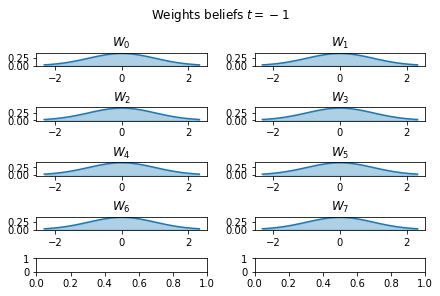

,slot1,slot2,slot3,reward
0,map,weather,reviews,1
1,map,weather,destination_guide,1
2,map,pricing,reviews,1
3,map,city_info,destination_guide,1
4,suit_style,pricing,reviews,1


Running iteration 0


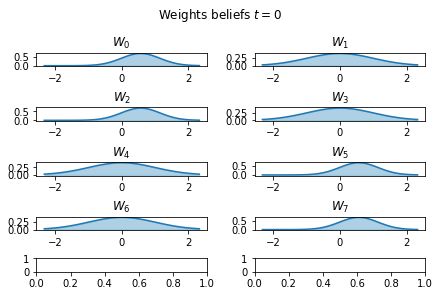

Running iteration 1


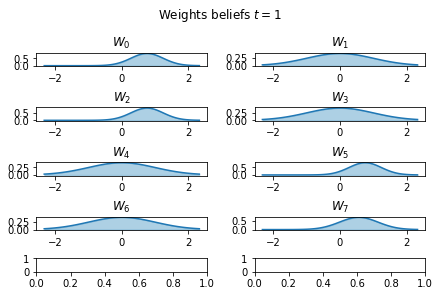

Running iteration 2


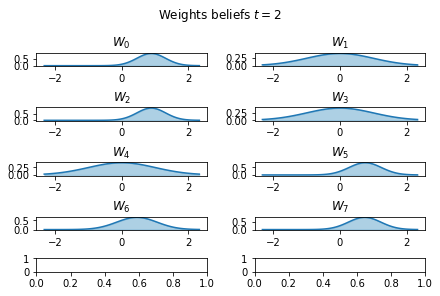

Running iteration 3


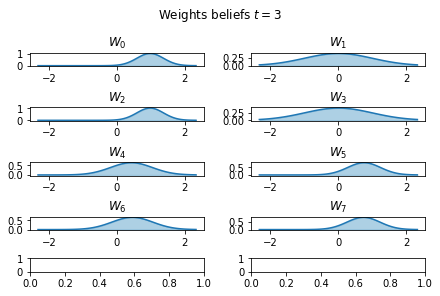

In [226]:
# time iterations
t = 4

# number of dimensions
d = 9

# initial weights
mu = np.zeros(d, np.float32)
sigma = np.ones(d, np.float32)

plot_weights(mu, sigma, -1)

H = simulate(H)
display(H)

# compute the feature vectors for each
features = to_features(H)

for i in range(t):
    print("Running iteration {}".format(i))
    row = H.iloc[i]
    feature = np.array(features.iloc[i].to_list())
    reward = row['reward']
        
    mu, sigma = update(mu, sigma, feature, reward)
    
    plot_weights(mu, sigma, i)

## Thompson Sampling

solve $\arg \max_A B^T_{A, X} W$

- for all $t = 1, \ldots, T$ do
    - receive context $X_t$
    - sample $W_T$ from the posterior $P(W|H_{t-1})$
    - select $A_t = \arg \max_A B^T_{A, X_t} W_t$
    - display layout $A_t$ and observe reward $R_t$
    - update $H_t = H_{t-1} \cup (A_t, R_t, X_t)$

In [227]:
w_tilde = np.random.normal(mu, sigma)

s1 = pd.Series(['top_rated', 'pricing', 'reviews'], index=["slot1", "slot2", "slot3"])
df = H.append(s1, ignore_index=True)

display(H)

b1 = np.array(to_features(H))
#display(b1)

c1 = np.sum(b1*w_tilde)

display(norm.cdf(c1))

norm.cdf([c1])

,slot1,slot2,slot3,reward
0,map,weather,reviews,1
1,map,weather,destination_guide,1
2,map,pricing,reviews,1
3,map,city_info,destination_guide,1
4,suit_style,pricing,reviews,1


1.0

array([1.])

In [228]:
def search_space():
    """returns a DataFrame with one hot encoding of values"""
    
    b = itertools.product(choices_slot_1, choices_slot_2, choices_slot_3)
    S = pd.DataFrame(data=b, columns=["slot1", "slot2", "slot3"], dtype='category')
    S["slot1"] = S["slot1"].cat.set_categories(choices_slot_1)
    S["slot2"] = S["slot2"].cat.set_categories(choices_slot_2)
    S["slot3"] = S["slot3"].cat.set_categories(choices_slot_3)    
    return S

def thompson_step(mu, sigma, H):

    # get context
    
    # sample from the posterior for each of the weights
    w = np.random.normal(mu, sigma)
        
    # generate the search space
    # convert to a matrix
    S = search_space()
    St = to_features(S)
    s = St.values
    
    # compute the posteriors for each
    s = np.sum(w * s, axis=1)
    s = norm.cdf(s)

    # find the most likely layout to receive reward
    best_index = np.argmax(s)
    best_layout = St.iloc[[best_index]]
    
    #simulate and observe behavior
    choices = to_categories(best_layout, columns=["slot1", "slot2", "slot3"])
    reward = simulate_behavior(*choices)
    
    #display("Choosing", choices)
    #display("Got Reward", reward)
    
    mu, sigma = update(mu, sigma, best_layout.values, reward)
    
    # add the result to history
    choices["reward"] = reward
    H = H.append(choices, ignore_index=True)
        
    return mu, sigma, H
    
    

In [231]:
S = search_space()
d = 9
N = 200

display("Search space", S)

mu = np.zeros(d)
sigma = np.ones(d)

H = pd.DataFrame(columns=["slot1", "slot2", "slot3", "reward"])

for t in range(N):
    mu, sigma, H = thompson_step(mu, sigma, H)
    
    
display(H)

'Search space'

,slot1,slot2,slot3
0,suit_style,city_info,reviews
1,suit_style,city_info,destination_guide
2,suit_style,weather,reviews
3,suit_style,weather,destination_guide
4,suit_style,pricing,reviews
5,suit_style,pricing,destination_guide
6,map,city_info,reviews
7,map,city_info,destination_guide
8,map,weather,reviews
9,map,weather,destination_guide


,slot1,slot2,slot3,reward
0,suit_style,weather,destination_guide,1
1,map,pricing,reviews,1
2,top_rated,weather,reviews,1
3,top_rated,weather,reviews,1
4,top_rated,weather,reviews,-1
...,...,...,...,...
195,map,pricing,destination_guide,1
196,map,pricing,destination_guide,1
197,suit_style,pricing,destination_guide,1
198,map,pricing,destination_guide,1


# Regret 

Regret is the difference of the expected value of the optimal strategy and the reward received that iteration.

\begin{equation*}
r = \frac{1}{T} \sum_{t=1}^{T} \mathbb{E}(R|A_t,X_t) - R_t
\end{equation*}

_local regret_ is the average of regret over a moving window with bounds $t_0$ to $t_1$.

\begin{equation*}
r = \frac{1}{1+t_1-t_0} \sum_{t=t_0}^{t_1} \mathbb{E}(R|A_t,X_t) - R_t
\end{equation*}

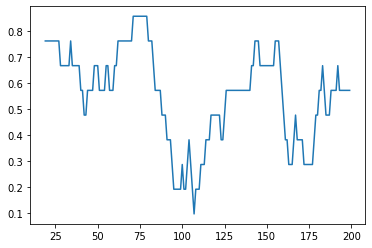

In [241]:
window = 20
x = np.linspace(0, 100, 1)
y = 1/(1+window) * H["reward"].rolling(window).sum()

plt.plot(y)


# Todo:

- Add pairwise effects
- Add context